In [4]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf


Instructions for updating:
Use `tf.global_variables_initializer` instead.
((30, 512, 80, 1), array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0], dtype=int32))
((30, 512, 80, 1), array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1], dtype=int32))
((30, 512, 80, 1), array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0], dtype=int32))
ERROR:tensorflow:Exception in QueueRunner: Enqueue operation was cancelled
	 [[Node: shuffle_batch/random_shuffle_queue_enqueue = QueueEnqueueV2[Tcomponents=[DT_FLOAT, DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch/random_shuffle_queue, sub, Cast_1)]]
ERROR:tensorflow:Exception in QueueRunner: Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replic

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/user/anaconda2/envs/tensorflow/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/user/anaconda2/envs/tensorflow/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/user/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/training/queue_runner_impl.py", line 238, in _run
    enqueue_callable()
  File "/home/user/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 1235, in _single_operation_run
    target_list_as_strings, status, None)
  File "/home/user/anaconda2/envs/tensorflow/lib/python2.7/contextlib.py", line 24, in __exit__
    self.gen.next()
  File "/home/user/anaconda2/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/errors_impl.py", line 466, in raise_exception_on_not_ok_status
    pywrap_tensorflow.TF_GetCode(status))


In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

In [8]:
# Parameters
learning_rate = 0.001 #学习率
num_steps = 30000  #迭代次数
batch_size = 64 #每次迭代选取的样本数

# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels，输入层神经元个数
hidden_dim = 512 #编码层/解码层神经元个数
latent_dim = 2 #隐藏层神经元个数

# A custom initialization (see Xavier Glorot init) 自定义一个初始化器，以正态分布的方式初始化变量
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.)) #返回正态分布随机数

In [9]:
# define Variables：用字典的方式存储各隐藏层的参数
# 权重weight和偏置bias的变化，在编码层和解码层顺序是相逆的  
# 权重参数矩阵维度是该层的 输入*输出[784,10] ，偏置参数维度取决于该层 输出层的单元数[10] 
#画图来讲
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [10]:
# Building the encoder
#因为encoder一般是神经网络模型
# 故每一层结构都是 xW + b （看图） 
# 构建编码器  
input_image = tf.placeholder(tf.float32, shape=[None, image_dim]) #输入数据,
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
#采样隐变量z，输入到decoder中去“重构”图片
#首先得构造一个服从标准正态分布的随机变量：eps
#利用eps和z_mean,z_std去合成z，使得z服从高斯分布，
#此时梯度也能进行回传
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [11]:
# Define VAE Loss定义损失函数
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss 使得重构图片与原始图片的差异最小
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss 使得z的分布与标准正态分布之间的差异最小
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)#总的差异是这两者的差异相加

loss_op = vae_loss(decoder, input_image) #创建实例，调用方法
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate) #调用优化器进行优化
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer() #初始化所有变量

In [12]:
# Start Training 开始训练
# Start a new TF session 创建一个tensorflow会话，所有的计算图都要在会话中执行
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data准备数据
    # Get the next batch of MNIST data (only images are needed, not labels) 
    #取得下一个训练数据样本（由于样本太大，需要分批次训练）
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Train ，每一批训练完以后，将其他训练批次的样本数据喂给输入
    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1: #从第一次迭代开始，每隔1000次打印一次迭代次数以及损失率
        print('Step %i, Loss: %f' % (i, l))

Step 1, Loss: 653.999634
Step 1000, Loss: 179.082779
Step 2000, Loss: 169.274689
Step 3000, Loss: 164.535980
Step 4000, Loss: 154.110107
Step 5000, Loss: 150.316376
Step 6000, Loss: 169.324692
Step 7000, Loss: 161.251160
Step 8000, Loss: 156.551270
Step 9000, Loss: 156.800903
Step 10000, Loss: 164.830032
Step 11000, Loss: 154.685577
Step 12000, Loss: 142.364914
Step 13000, Loss: 149.440948
Step 14000, Loss: 165.764221
Step 15000, Loss: 151.103394
Step 16000, Loss: 155.898560
Step 17000, Loss: 157.050171
Step 18000, Loss: 140.588104
Step 19000, Loss: 144.428894
Step 20000, Loss: 130.521713
Step 21000, Loss: 155.413712
Step 22000, Loss: 154.902740
Step 23000, Loss: 149.727783
Step 24000, Loss: 155.981079
Step 25000, Loss: 146.499939
Step 26000, Loss: 149.674469
Step 27000, Loss: 150.756210
Step 28000, Loss: 144.103104
Step 29000, Loss: 140.941681
Step 30000, Loss: 148.864212


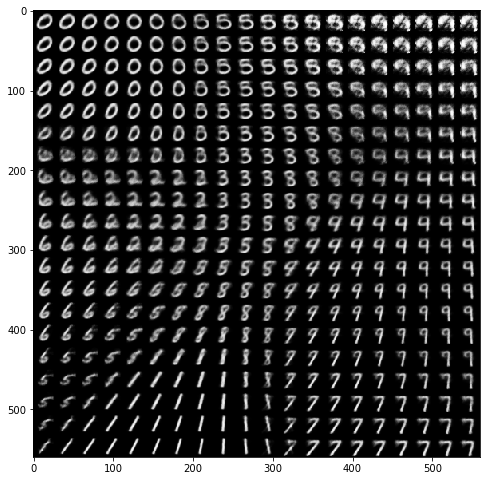

In [13]:
# Testing 测试
# Generator takes noise as input 
#把含有噪声的数据当作隐变量（本质上就是高斯随机分布向量）输入到decoder中
#（此时decoder就相当于一个图片生成器了）
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])

# Rebuild the decoder to create image from noise
#重建decoder，由给的高斯随机分布向量中去生成新的图片（此处有不足，可改进）
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

# Building a manifold of generated digits
#可视化生成的图片（主要用到matplot.pylot和numpy库中的相关函数）
n = 20 #一张20×20的可视化图
x_axis = np.linspace(-3, 3, n) #函数返回20个具有相同间隔的采样值，数据的间隔通过计算获得
y_axis = np.linspace(-3, 3, n) 

canvas = np.empty((28 * n, 28 * n))#创建一个28×20行，28×20列的随机矩阵
for i, yi in enumerate(x_axis): #python的内建函数，返回索引，元素值
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)#返回一个2维数组
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu}) #通过feed_dict给noise_input传值
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
        x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10)) #指定绘图对象的分辨率，宽8×80像素，高10×80像素
Xi, Yi = np.meshgrid(x_axis, y_axis) #产生两个维度相同的矩阵
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()